Epoch 1/100
169/169 [==============================] - 1s 2ms/step - loss: 0.5158 - val_loss: 0.1642
Epoch 2/100
169/169 [==============================] - 0s 1ms/step - loss: 0.1426 - val_loss: 0.0398
Epoch 3/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0998 - val_loss: 0.0188
Epoch 4/100
169/169 [==============================] - 0s 1ms/step - loss: 0.1170 - val_loss: 0.0197
Epoch 5/100
169/169 [==============================] - 0s 1ms/step - loss: 0.1701 - val_loss: 0.0269
Epoch 6/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0236 - val_loss: 0.0118
Epoch 7/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0162 - val_loss: 0.0609
Epoch 8/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0493 - val_loss: 0.0391
Epoch 9/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0843 - val_loss: 0.0064
Epoch 10/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0125 - val_lo

C:\Users\remy\AppData\Local\Temp\ipykernel_2760\2735630746.py:97: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model)
c:\Users\remy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\remy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_scor

Epoch 1/100
169/169 [==============================] - 7s 35ms/step - loss: 546760.2500
Epoch 2/100
169/169 [==============================] - 6s 35ms/step - loss: 265967.0625
Epoch 3/100
169/169 [==============================] - 6s 34ms/step - loss: 234380.0625
Epoch 4/100
169/169 [==============================] - 6s 34ms/step - loss: 210403.2188
Epoch 5/100
169/169 [==============================] - 6s 35ms/step - loss: 206092.0156
Epoch 6/100
169/169 [==============================] - 6s 34ms/step - loss: 197466.7500
Epoch 7/100
169/169 [==============================] - 6s 34ms/step - loss: 194361.1562
Epoch 8/100
169/169 [==============================] - 6s 34ms/step - loss: 201279.1719
Epoch 9/100
169/169 [==============================] - 6s 35ms/step - loss: 202102.6562
Epoch 10/100
169/169 [==============================] - 6s 35ms/step - loss: 209329.9219
Epoch 11/100
169/169 [==============================] - 6s 36ms/step - loss: 199846.4531
Epoch 12/100
169/169 [========

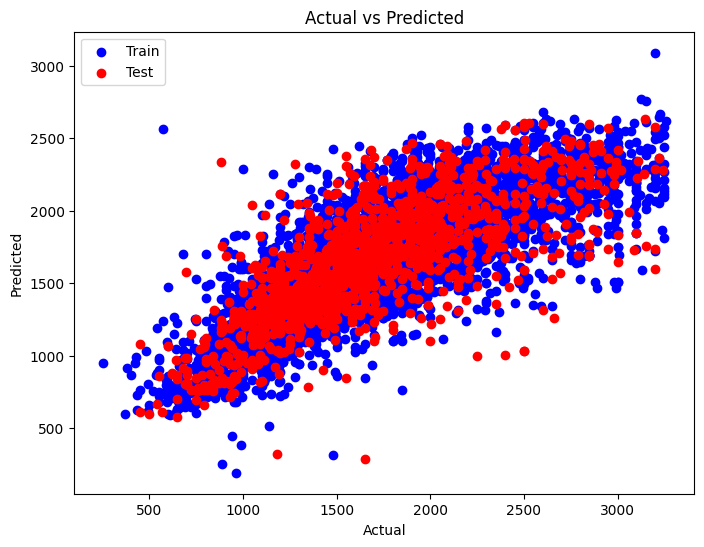

ValueError: Data must be 1-dimensional, got ndarray of shape (5380, 5380) instead

<Figure size 800x600 with 0 Axes>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

# Load the cleaned dataset
df = pd.read_csv("swiss_no_outliers_and_cleaned.csv")

# Select features and target variable
X = df[["Rooms", "Footage", "Distance_to_City_Center(km)", "Address_Latitude", "Address_Longitude"]]
y = df["Rent"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the input data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Define the input layer
input_data = Input(shape=(5,))

# Define the encoder
encoded = Dense(64, activation='relu')(input_data)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

# Define the bottleneck (compressed representation)
bottleneck = Dense(8, activation='relu')(encoded)

# Define the decoder
decoded = Dense(16, activation='relu')(bottleneck)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(64, activation='relu')(decoded)

# Define the output layer
output_data = Dense(5, activation='linear')(decoded)

# Create the autoencoder model
autoencoder = Model(input_data, output_data)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder model
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32, validation_split=0.2)

# Extract the encoder part of the autoencoder
encoder = Model(input_data, bottleneck)

# Generate a lower-dimensional representation of your input data
X_encoded = encoder.predict(X_scaled)

# Reshape the encoded data into a suitable format for RNNs, LSTMs, or GRUs
timesteps = 2
features = 4
X_encoded_reshaped = X_encoded.reshape((-1, timesteps, features))

# Split the reshaped data into training and testing sets
X_encoded_train, X_encoded_test, y_train, y_test = train_test_split(X_encoded_reshaped, y_train, test_size=0.2, random_state=42)

def create_model(model_type, units, learning_rate, dropout_rate):
    model = Sequential()

    if model_type == "RNN":
        model.add(SimpleRNN(units, input_shape=(timesteps, features), activation='relu', return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(SimpleRNN(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    elif model_type == "LSTM":
        model.add(LSTM(units, input_shape=(timesteps, features), activation='relu', return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    elif model_type == "GRU":
        model.add(GRU(units, input_shape=(timesteps, features), activation='relu', return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(GRU(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    elif model_type == "DNN":
        model.add(Dense(units, input_shape=(timesteps*features,), activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
    return model

model = KerasRegressor(build_fn=create_model)

param_grid = {
    'model_type': ['RNN', 'LSTM', 'GRU', 'DNN'],
    'units': [128, 256, 512],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.05, 0.01, 0.005],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150],
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, n_jobs=-1, cv=3, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the data.
random_search_result = random_search.fit(X_encoded_train, y_train)

# Get the cv_results_ before converting to DataFrame.
cv_results = random_search_result.cv_results_

# Then convert cv_results to a DataFrame.
random_search_result_df = pd.DataFrame(cv_results)

# Save this DataFrame to a csv file.
random_search_result_df.to_csv('randomized_search_results.csv', index=False)

# Extract the needed information.
best_models = cv_results['params']
best_mses = -cv_results['mean_test_score']

for i, model_params in enumerate(best_models):
    print(f"Model {i+1}:")
    for param, value in model_params.items():
        print(f"{param}: {value}")
    print(f"MSE: {best_mses[i]}")
    print()

best_model = random_search_result.best_estimator_.model
best_model.save("best_model.h5")

y_pred_train = best_model.predict(X_encoded_train)
y_pred_test = best_model.predict(X_encoded_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"MSE (Train): {mse_train}, MSE (Test): {mse_test}")
print(f"R2 (Train): {r2_train}, R2 (Test): {r2_test}")

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred_train, color='blue', label='Train')
plt.scatter(y_test, y_pred_test, color='red', label='Test')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(8, 6))
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test
plt.scatter(y_pred_train, residuals_train, color='blue', label='Train')
plt.scatter(y_pred_test, residuals_test, color='red', label='Test')
plt.hlines(y=0, xmin=np.min(y_pred_train), xmax=np.max(y_pred_train), color='black')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()


In [2]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Load the model
best_model = load_model("best_model.h5")

# Initialize StandardScaler
scaler = StandardScaler()

# Define the input
input_data = {
    "Rooms": [2.5],  # replace with actual value
    "Footage": [80],  # replace with actual value
    "Distance_to_City_Center(km)": [2.98],  # replace with actual value
    "Address_Latitude": [47.395589],  # replace with actual value
    "Address_Longitude": [8.540417],  # replace with actual value
}

# Create a DataFrame from the input
df_input = pd.DataFrame(input_data)

# Scale the input data
input_scaled = scaler.fit_transform(df_input)

# Reshape the input data into a suitable format for RNNs, LSTMs, or GRUs
timesteps = 2
features = 4
input_scaled_reshaped = input_scaled.reshape((-1, timesteps, features))

# Predict the rent
predicted_rent = best_model.predict(input_scaled_reshaped)

print("The estimated rent for the apartment is: ", predicted_rent[0])


OSError: No file or directory found at encoder.h5